In [ ]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Problem 3

In [ ]:
### Problem 3.1

# Prior class probabilities with Laplace Smoothing
logye, logyj, logys = np.log((10 + 1/2)/(30 + 3/2)), np.log((10 + 1/2)/(30 + 3/2)), np.log((10 + 1/2)/(30 + 3/2))

np.exp(logye), np.exp(logyj), np.exp(logys)

In [ ]:
# Compute the count for each letter in the document given by file with name fname
def get_counts(fname):
    x = np.zeros(27, dtype=int)
    
    with open(fname) as f:
        for line in f:
            for ch in line.strip():
                if ch == ' ':
                    x[26] += 1
                else:
                    x[ord(ch)-ord('a')] += 1
                    
    return x

In [ ]:
# Assume 0-9 -> english, 10-19 -> japanese, 20 -> 29 -> spanish
# Example: 15 -> j5.txt
def get_filename(idx):
    pfx = ['e', 'j', 's']
    return f'../languageID/{pfx[idx//10]}{idx%10}.txt'

In [ ]:
# Y -> {e: 0, j: 1, s: 2}
# X -> character count for each document
def get_train_data():
    Y = np.array([i//10 for i in np.arange(30)])
    X = np.array([get_counts(get_filename(idx)) for idx in np.arange(30)])
    
    return X, Y

In [ ]:
X, Y = get_train_data()

In [ ]:
### Problem 3.2

# idx determines the lang {e: 0, j: 1, s: 2}
def calc_params(idx):
    # Accumulate counts for language idx
    p = X[idx*10:(idx+1)*10].sum(axis=0)

    # Laplace Smoothing (and broadcasting)
    p = p + 1/2

    # Normalize
    return p / p.sum()

In [ ]:
pe, pj, ps = calc_params(0), calc_params(1), calc_params(2)

# Conditional prob of each char given class label
pe, pj, ps

In [ ]:
# Latex output

def latex_table(pl):
    headers = ['character', '$p(c \mid e)$']

    textabular = '|| c | c ||'
    texheader = " & ".join(headers) + "\\\\"
    texdata = "\\hline\\hline\n"
    for i, p in enumerate(p):
        if i == 26:
            c = 'SPACE'
        else:
            c = chr(ord('a') + i)
        texdata += f'{c} & {p:.3f}\\\\\n'
        texdata += "\\hline\n"

    print("\\begin{tabular}{"+textabular+"}")
    print("\\hline")
    print(texheader)
    print(texdata,end="")
    print("\\end{tabular}")

In [ ]:
### Problem 3.3

latex_table(ps)

In [ ]:
### Problem 3.4

xtest = get_counts(f'../languageID/e10.txt')

xtest

In [ ]:
# Latex output

headers = ['character', 'count']

textabular = '|| c | c ||'
texheader = " & ".join(headers) + "\\\\"
texdata = "\\hline\\hline\n"
for i, p in enumerate(xtest):
    if i == 26:
        c = 'SPACE'
    else:
        c = chr(ord('a') + i)
    texdata += f'{c} & {p:}\\\\\n'
    texdata += "\\hline\n"

print("\\begin{tabular}{"+textabular+"}")
print("\\hline")
print(texheader)
print(texdata,end="")
print("\\end{tabular}")

In [ ]:
### Problem 3.5

xtest.T @ np.log(pe), xtest.T @ np.log(pj), xtest.T @ np.log(ps)

In [ ]:
### Problem 3.7

cm = np.zeros((3, 3), dtype=int)
labels = ['e', 'j', 's']

for label in range(3):
    for idx in range(10):
        fname = f'../languageID/{labels[label]}{idx}.txt'
        xtest = get_counts(fname)
        likelihood = np.array([xtest.T @ np.log(pe) + logye, xtest.T @ np.log(pj) + logyj, xtest.T @ np.log(ps) + logys])
        pred = np.argmax(likelihood)
        cm[pred, label] += 1
        
cm

In [ ]:
## Problem 4

In [ ]:
### Problem 4.2

In [11]:
# Required packages

import math
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [12]:
#### Settings

d = 28 * 28
d1 = 300
k = 10
lr = 1e-2

In [13]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [14]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [15]:
# Model in question
class MLP:
    def __init__(self):
        
        # Hidden Layer
        self.w1 = torch.empty((d1, d))
        self.b1 = torch.empty(d1)
        nn.init.kaiming_uniform_(self.w1, a=math.sqrt(5))
        bound = 1 / math.sqrt(d)
        nn.init.uniform_(self.b1, -bound, bound)
        
        # Output Layer
        self.w2 = torch.empty((k, d1))
        self.b2 = torch.empty(k)
        nn.init.kaiming_uniform_(self.w2, a=math.sqrt(5))
        bound = 1 / math.sqrt(d1)
        nn.init.uniform_(self.b2, -bound, bound)
        
    def backprop(self, X, Y):
        ## Forward Pass
        
        # Hidden Layer
        N = X.size(0)
        flat = X.view(N, -1)
        lin1 = flat @ self.w1.T + self.b1
        h1 = torch.sigmoid(lin1) # sigmoid non-linearity
        
        # Output Layer
        logits = h1 @ self.w2.T + self.b2
        
        # Softmax
        maxb, _ = torch.max(logits, axis=1, keepdim=True)
        logits = logits - maxb # Keep the values non-positive to avoid blowing up the exponents
        p = torch.exp(logits)
        p = p / p.sum(axis=1, keepdim=True) # Softmax
        
        # Cross Entropy
        loss = -torch.mean(torch.log(torch.gather(p, 1, Y.unsqueeze(dim=1)))).item()
        
        ## Backward Pass
        # cross_entropy grad
        dout = (p - F.one_hot(Y)) / N

        # Output Layer grad
        dw2 = torch.sum(dout.unsqueeze(dim=2) @ h1.unsqueeze(dim=1), axis=0)
        db2 = dout.sum(axis=0)
        dh1 = dout @ self.w2

        # Hidden Layer grad
        dlin1 = dh1 * h1 * (1 - h1)
        dw1 = torch.sum(dlin1.unsqueeze(dim=2) @ flat.unsqueeze(dim=1), axis=0)
        db1 = dlin1.sum(axis=0)
        
        # Update
        self.w2 = self.w2 - lr * dw2
        self.b2 = self.b2 - lr * db2
        self.w1 = self.w1 - lr * dw1
        self.b1 = self.b1 - lr * db1
        
        return loss
    
    def evaluate(self, X, Y):
        ## Forward Pass
        
        # Hidden Layer
        N = X.size(0)
        flat = X.view(N, -1)
        lin1 = flat @ self.w1.T + self.b1
        h1 = torch.sigmoid(lin1) # sigmoid non-linearity
        
        # Output Layer
        logits = h1 @ self.w2.T + self.b2
        
        # Softmax
        maxb, _ = torch.max(logits, axis=1, keepdim=True)
        logits = logits - maxb # Keep the values non-positive to avoid blowing up the exponents
        p = torch.exp(logits)
        p = p / p.sum(axis=1, keepdim=True) # Softmax
        
        # Cross Entropy
        loss = -torch.mean(torch.log(torch.gather(p, 1, Y.unsqueeze(dim=1)))).item()
        
        # Compute num correct
        correct = (logits.argmax(dim=1) == Y).type(torch.float).sum().item()
        
        return loss, correct
    
    def copy_params(self):
        self.w1, self.b1 = linear1.weight.clone(), linear1.bias.clone()
        self.w2, self.b2 = linear2.weight.clone(), linear2.bias.clone()
        
    
mlp = MLP()

In [16]:
def train(dataloader):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute loss
        loss = mlp.backprop(X, y)

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [17]:
def test(dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    for X, y in dataloader:
        loss, ncorrect = mlp.evaluate(X, y)
        test_loss += loss
        correct += ncorrect
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [18]:
epochs = 75
xs = []
test_losses = []
test_accs = []
for t in range(epochs):
    train(train_dataloader)
    test_loss, test_acc = test(test_dataloader)
    xs.append(t)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
test_error = 1 - test_acc

test_error

loss: 2.350389  [   64/60000]
loss: 2.258466  [ 6464/60000]
loss: 2.256941  [12864/60000]
loss: 2.203731  [19264/60000]
loss: 2.170727  [25664/60000]
loss: 2.137524  [32064/60000]
loss: 2.048639  [38464/60000]
loss: 2.074213  [44864/60000]
loss: 1.994132  [51264/60000]
loss: 1.889820  [57664/60000]
loss: 1.874526  [   64/60000]
loss: 1.768005  [ 6464/60000]
loss: 1.780634  [12864/60000]
loss: 1.623546  [19264/60000]
loss: 1.555864  [25664/60000]
loss: 1.511904  [32064/60000]
loss: 1.354600  [38464/60000]
loss: 1.486639  [44864/60000]
loss: 1.353354  [51264/60000]
loss: 1.225097  [57664/60000]
loss: 1.240410  [   64/60000]
loss: 1.126477  [ 6464/60000]
loss: 1.162853  [12864/60000]
loss: 1.035485  [19264/60000]
loss: 0.988895  [25664/60000]
loss: 0.982881  [32064/60000]
loss: 0.864401  [38464/60000]
loss: 1.047276  [44864/60000]
loss: 0.958479  [51264/60000]
loss: 0.864373  [57664/60000]
loss: 0.889566  [   64/60000]
loss: 0.794225  [ 6464/60000]
loss: 0.826997  [12864/60000]
loss: 0.75

loss: 0.229173  [25664/60000]
loss: 0.332057  [32064/60000]
loss: 0.211803  [38464/60000]
loss: 0.404648  [44864/60000]
loss: 0.351949  [51264/60000]
loss: 0.437697  [57664/60000]
loss: 0.236343  [   64/60000]
loss: 0.282233  [ 6464/60000]
loss: 0.214654  [12864/60000]
loss: 0.340220  [19264/60000]
loss: 0.226998  [25664/60000]
loss: 0.330030  [32064/60000]
loss: 0.209836  [38464/60000]
loss: 0.403003  [44864/60000]
loss: 0.348716  [51264/60000]
loss: 0.436794  [57664/60000]
loss: 0.232803  [   64/60000]
loss: 0.281150  [ 6464/60000]
loss: 0.211973  [12864/60000]
loss: 0.337998  [19264/60000]
loss: 0.224978  [25664/60000]
loss: 0.328098  [32064/60000]
loss: 0.207969  [38464/60000]
loss: 0.401475  [44864/60000]
loss: 0.345577  [51264/60000]
loss: 0.435874  [57664/60000]
loss: 0.229436  [   64/60000]
loss: 0.280127  [ 6464/60000]
loss: 0.209470  [12864/60000]
loss: 0.335851  [19264/60000]
loss: 0.223097  [25664/60000]
loss: 0.326250  [32064/60000]
loss: 0.206188  [38464/60000]
loss: 0.40

loss: 0.279341  [51264/60000]
loss: 0.404576  [57664/60000]
loss: 0.175295  [   64/60000]
loss: 0.260312  [ 6464/60000]
loss: 0.173749  [12864/60000]
loss: 0.294373  [19264/60000]
loss: 0.195570  [25664/60000]
loss: 0.293373  [32064/60000]
loss: 0.173105  [38464/60000]
loss: 0.376397  [44864/60000]
loss: 0.276853  [51264/60000]
loss: 0.403108  [57664/60000]
loss: 0.173788  [   64/60000]
loss: 0.259515  [ 6464/60000]
loss: 0.172804  [12864/60000]
loss: 0.292940  [19264/60000]
loss: 0.194726  [25664/60000]
loss: 0.292296  [32064/60000]
loss: 0.171943  [38464/60000]
loss: 0.375548  [44864/60000]
loss: 0.274370  [51264/60000]
loss: 0.401634  [57664/60000]
loss: 0.172310  [   64/60000]
loss: 0.258711  [ 6464/60000]
loss: 0.171874  [12864/60000]
loss: 0.291513  [19264/60000]
loss: 0.193882  [25664/60000]
loss: 0.291227  [32064/60000]
loss: 0.170785  [38464/60000]
loss: 0.374697  [44864/60000]
loss: 0.271891  [51264/60000]
loss: 0.400155  [57664/60000]
loss: 0.170860  [   64/60000]
loss: 0.25

0.06910000000000005

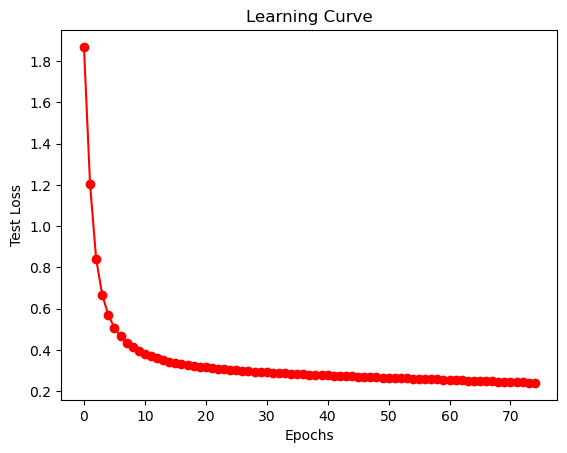

In [19]:
# Plot loss vs epochs

ax = plt.gca()

# Plotting
plt.plot(xs, test_losses, 'ro-')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Learning Curve')

plt.show()

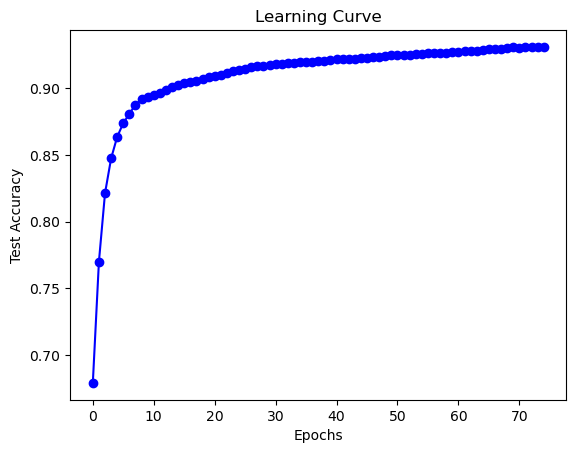

In [20]:
ax = plt.gca()

# Plotting
plt.plot(xs, test_accs, 'bo-')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Learning Curve')

plt.show()

In [21]:
### Problem 4.3

In [22]:
# Required packages

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [23]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [24]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [25]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.Sigmoid(),
            nn.Linear(300, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=10, bias=True)
  )
)


In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [27]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [28]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [29]:
epochs = 75
xs = []
test_losses = []
test_accs = []
for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    xs.append(t)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
test_error = 1 - test_acc

test_error

loss: 2.322742  [   64/60000]
loss: 2.258296  [ 6464/60000]
loss: 2.263289  [12864/60000]
loss: 2.201847  [19264/60000]
loss: 2.172127  [25664/60000]
loss: 2.141776  [32064/60000]
loss: 2.061494  [38464/60000]
loss: 2.083674  [44864/60000]
loss: 1.994950  [51264/60000]
loss: 1.892451  [57664/60000]
loss: 1.876874  [   64/60000]
loss: 1.772750  [ 6464/60000]
loss: 1.795981  [12864/60000]
loss: 1.630869  [19264/60000]
loss: 1.566502  [25664/60000]
loss: 1.530151  [32064/60000]
loss: 1.373803  [38464/60000]
loss: 1.498552  [44864/60000]
loss: 1.349747  [51264/60000]
loss: 1.224388  [57664/60000]
loss: 1.235494  [   64/60000]
loss: 1.120377  [ 6464/60000]
loss: 1.169884  [12864/60000]
loss: 1.038944  [19264/60000]
loss: 0.986603  [25664/60000]
loss: 0.993593  [32064/60000]
loss: 0.875044  [38464/60000]
loss: 1.053432  [44864/60000]
loss: 0.947616  [51264/60000]
loss: 0.852445  [57664/60000]
loss: 0.877259  [   64/60000]
loss: 0.780226  [ 6464/60000]
loss: 0.824170  [12864/60000]
loss: 0.75

loss: 0.230267  [25664/60000]
loss: 0.332483  [32064/60000]
loss: 0.212157  [38464/60000]
loss: 0.411983  [44864/60000]
loss: 0.350083  [51264/60000]
loss: 0.431796  [57664/60000]
loss: 0.226432  [   64/60000]
loss: 0.282202  [ 6464/60000]
loss: 0.215115  [12864/60000]
loss: 0.331445  [19264/60000]
loss: 0.228114  [25664/60000]
loss: 0.330570  [32064/60000]
loss: 0.210141  [38464/60000]
loss: 0.410260  [44864/60000]
loss: 0.346858  [51264/60000]
loss: 0.431218  [57664/60000]
loss: 0.222840  [   64/60000]
loss: 0.281329  [ 6464/60000]
loss: 0.212473  [12864/60000]
loss: 0.329047  [19264/60000]
loss: 0.226116  [25664/60000]
loss: 0.328750  [32064/60000]
loss: 0.208228  [38464/60000]
loss: 0.408646  [44864/60000]
loss: 0.343723  [51264/60000]
loss: 0.430620  [57664/60000]
loss: 0.219432  [   64/60000]
loss: 0.280511  [ 6464/60000]
loss: 0.210000  [12864/60000]
loss: 0.326740  [19264/60000]
loss: 0.224257  [25664/60000]
loss: 0.327012  [32064/60000]
loss: 0.206405  [38464/60000]
loss: 0.40

loss: 0.278050  [51264/60000]
loss: 0.406299  [57664/60000]
loss: 0.166522  [   64/60000]
loss: 0.264731  [ 6464/60000]
loss: 0.173760  [12864/60000]
loss: 0.284808  [19264/60000]
loss: 0.196938  [25664/60000]
loss: 0.295977  [32064/60000]
loss: 0.173303  [38464/60000]
loss: 0.379494  [44864/60000]
loss: 0.275643  [51264/60000]
loss: 0.405048  [57664/60000]
loss: 0.165115  [   64/60000]
loss: 0.264071  [ 6464/60000]
loss: 0.172780  [12864/60000]
loss: 0.283456  [19264/60000]
loss: 0.196083  [25664/60000]
loss: 0.294939  [32064/60000]
loss: 0.172169  [38464/60000]
loss: 0.378469  [44864/60000]
loss: 0.273246  [51264/60000]
loss: 0.403788  [57664/60000]
loss: 0.163737  [   64/60000]
loss: 0.263403  [ 6464/60000]
loss: 0.171816  [12864/60000]
loss: 0.282114  [19264/60000]
loss: 0.195228  [25664/60000]
loss: 0.293906  [32064/60000]
loss: 0.171040  [38464/60000]
loss: 0.377441  [44864/60000]
loss: 0.270859  [51264/60000]
loss: 0.402518  [57664/60000]
loss: 0.162388  [   64/60000]
loss: 0.26

0.06840000000000002

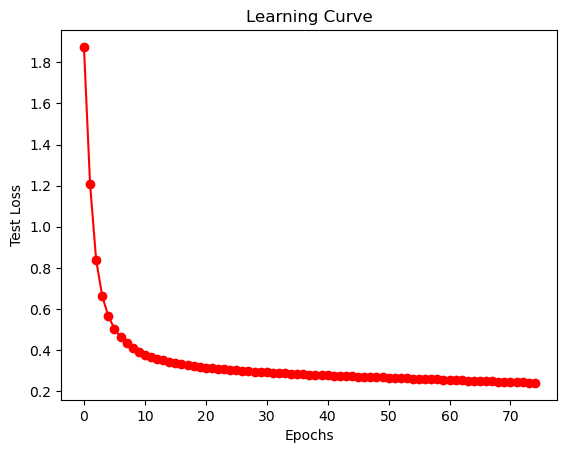

In [30]:
# Plot loss vs epochs

ax = plt.gca()

# Plotting
plt.plot(xs, test_losses, 'ro-')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Learning Curve')

plt.show()

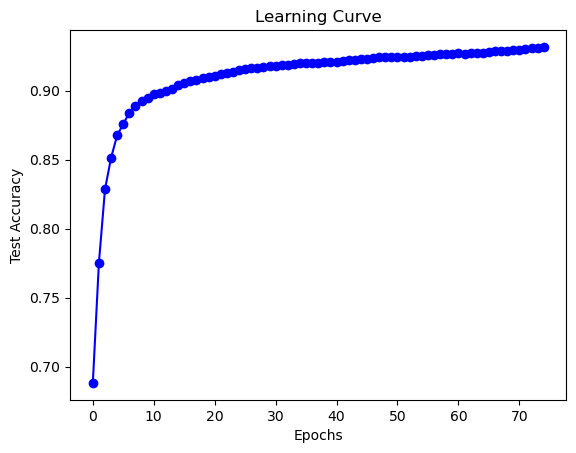

In [31]:
ax = plt.gca()

# Plotting
plt.plot(xs, test_accs, 'bo-')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Learning Curve')

plt.show()

In [ ]:
### Problem 4.4

In [1]:
# Required packages

import math
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [2]:
def plot_mangrad_learning_curve(w1, b1, w2, b2):
    #### Settings

    d = 28 * 28
    d1 = 300
    k = 10
    lr = 1e-2
    
    batch_size = 64
    
    # Download training data from open datasets.
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    
    # Model in question
    class MLP:
        def __init__(self):

            # Hidden Layer
            self.w1 = torch.empty((d1, d))
            self.b1 = torch.empty(d1)
            nn.init.kaiming_uniform_(self.w1, a=math.sqrt(5))
            bound = 1 / math.sqrt(d)
            nn.init.uniform_(self.b1, -bound, bound)

            # Output Layer
            self.w2 = torch.empty((k, d1))
            self.b2 = torch.empty(k)
            nn.init.kaiming_uniform_(self.w2, a=math.sqrt(5))
            bound = 1 / math.sqrt(d1)
            nn.init.uniform_(self.b2, -bound, bound)

        def backprop(self, X, Y):
            ## Forward Pass

            # Hidden Layer
            N = X.size(0)
            flat = X.view(N, -1)
            lin1 = flat @ self.w1.T + self.b1
            h1 = torch.sigmoid(lin1) # sigmoid non-linearity

            # Output Layer
            logits = h1 @ self.w2.T + self.b2

            # Softmax
            maxb, _ = torch.max(logits, axis=1, keepdim=True)
            logits = logits - maxb # Keep the values non-positive to avoid blowing up the exponents
            p = torch.exp(logits)
            p = p / p.sum(axis=1, keepdim=True) # Softmax

            # Cross Entropy
            loss = -torch.mean(torch.log(torch.gather(p, 1, Y.unsqueeze(dim=1)))).item()

            ## Backward Pass
            # cross_entropy grad
            dout = (p - F.one_hot(Y)) / N

            # Output Layer grad
            dw2 = torch.sum(dout.unsqueeze(dim=2) @ h1.unsqueeze(dim=1), axis=0)
            db2 = dout.sum(axis=0)
            dh1 = dout @ self.w2

            # Hidden Layer grad
            dlin1 = dh1 * h1 * (1 - h1)
            dw1 = torch.sum(dlin1.unsqueeze(dim=2) @ flat.unsqueeze(dim=1), axis=0)
            db1 = dlin1.sum(axis=0)

            # Update
            self.w2 = self.w2 - lr * dw2
            self.b2 = self.b2 - lr * db2
            self.w1 = self.w1 - lr * dw1
            self.b1 = self.b1 - lr * db1

            return loss

        def evaluate(self, X, Y):
            ## Forward Pass

            # Hidden Layer
            N = X.size(0)
            flat = X.view(N, -1)
            lin1 = flat @ self.w1.T + self.b1
            h1 = torch.sigmoid(lin1) # sigmoid non-linearity

            # Output Layer
            logits = h1 @ self.w2.T + self.b2

            # Softmax
            maxb, _ = torch.max(logits, axis=1, keepdim=True)
            logits = logits - maxb # Keep the values non-positive to avoid blowing up the exponents
            p = torch.exp(logits)
            p = p / p.sum(axis=1, keepdim=True) # Softmax

            # Cross Entropy
            loss = -torch.mean(torch.log(torch.gather(p, 1, Y.unsqueeze(dim=1)))).item()

            # Compute num correct
            correct = (logits.argmax(dim=1) == Y).type(torch.float).sum().item()

            return loss, correct

        def copy_params(self):
            self.w1, self.b1 = linear1.weight.clone(), linear1.bias.clone()
            self.w2, self.b2 = linear2.weight.clone(), linear2.bias.clone()


    mlp = MLP()
    mlp.w1 = w1.clone()
    mlp.b1 = b1.clone()
    mlp.w2 = w2.clone()
    mlp.b2 = b2.clone()
    
    def train(dataloader):
        size = len(dataloader.dataset)
        for batch, (X, y) in enumerate(dataloader):
            # Compute loss
            loss = mlp.backprop(X, y)

            if batch % 100 == 0:
                current = (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                
    def test(dataloader):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0
        for X, y in dataloader:
            loss, ncorrect = mlp.evaluate(X, y)
            test_loss += loss
            correct += ncorrect
        test_loss /= num_batches
        correct /= size
        # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        return test_loss, correct
    
    epochs = 75
    xs = []
    test_losses = []
    test_accs = []
    for t in range(epochs):
        train(train_dataloader)
        test_loss, test_acc = test(test_dataloader)
        xs.append(t)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    test_error = 1 - test_acc
    print(f'{test_error=}')
    
    # Plot loss vs epochs

    ax = plt.gca()

    # Plotting
    plt.plot(xs, test_losses, 'ro-')

    # Labels and Title
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Learning Curve')

    plt.show()
    
    ax = plt.gca()

    # Plotting
    plt.plot(xs, test_accs, 'bo-')

    # Labels and Title
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Learning Curve')

    plt.show()

In [3]:
def plot_autograd_learning_curve(w1, b1, w2, b2):
    # Download training data from open datasets.
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )
    
    batch_size = 64

    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)
    
    # Define model
    class NeuralNetwork(nn.Module):
        def __init__(self):
            lin1 = nn.Linear(28*28, d1)
            lin1.weight = nn.Parameter(w1.clone())
            lin1.bias = nn.Parameter(b1.clone())
            lin2 = nn.Linear(d1, k)
            lin2.weight = nn.Parameter(w2.clone())
            lin2.bias = nn.Parameter(b2.clone())
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear_sigmoid_stack = nn.Sequential(
                lin1,
                nn.Sigmoid(),
                lin2,
            )

        def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_sigmoid_stack(x)
            return logits

    model = NeuralNetwork()
    print(model)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    
    def train(dataloader, model, loss_fn, optimizer):
        size = len(dataloader.dataset)
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                
    def test(dataloader, model, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        return test_loss, correct
    
    epochs = 75
    xs = []
    test_losses = []
    test_accs = []
    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_acc = test(test_dataloader, model, loss_fn)
        xs.append(t)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    test_error = 1 - test_acc

    print(f'{test_error=}')
    
    # Plot loss vs epochs

    ax = plt.gca()

    # Plotting
    plt.plot(xs, test_losses, 'ro-')

    # Labels and Title
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Learning Curve')

    plt.show()
    
    ax = plt.gca()

    # Plotting
    plt.plot(xs, test_accs, 'bo-')

    # Labels and Title
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Learning Curve')

    plt.show()

In [4]:
# Settings

d = 28 * 28
d1 = 300
k = 10

In [5]:
## Zero weights and biases

w1 = torch.zeros((d1, d))
b1 = torch.zeros(d1)
w2 = torch.zeros((k, d1))
b2 = torch.zeros(k)

loss: 2.302585  [   64/60000]
loss: 2.296577  [ 6464/60000]
loss: 2.318174  [12864/60000]
loss: 2.310963  [19264/60000]
loss: 2.312971  [25664/60000]
loss: 2.310614  [32064/60000]
loss: 2.301440  [38464/60000]
loss: 2.307638  [44864/60000]
loss: 2.308934  [51264/60000]
loss: 2.290890  [57664/60000]
loss: 2.303029  [   64/60000]
loss: 2.296514  [ 6464/60000]
loss: 2.317945  [12864/60000]
loss: 2.311059  [19264/60000]
loss: 2.313009  [25664/60000]
loss: 2.310534  [32064/60000]
loss: 2.301274  [38464/60000]
loss: 2.307734  [44864/60000]
loss: 2.308970  [51264/60000]
loss: 2.290829  [57664/60000]
loss: 2.302955  [   64/60000]
loss: 2.296440  [ 6464/60000]
loss: 2.317697  [12864/60000]
loss: 2.311158  [19264/60000]
loss: 2.313043  [25664/60000]
loss: 2.310441  [32064/60000]
loss: 2.301090  [38464/60000]
loss: 2.307832  [44864/60000]
loss: 2.309005  [51264/60000]
loss: 2.290755  [57664/60000]
loss: 2.302869  [   64/60000]
loss: 2.296356  [ 6464/60000]
loss: 2.317421  [12864/60000]
loss: 2.31

loss: 1.078924  [25664/60000]
loss: 1.100018  [32064/60000]
loss: 1.034401  [38464/60000]
loss: 1.256264  [44864/60000]
loss: 1.095291  [51264/60000]
loss: 1.108344  [57664/60000]
loss: 1.075924  [   64/60000]
loss: 1.131837  [ 6464/60000]
loss: 1.224137  [12864/60000]
loss: 1.074400  [19264/60000]
loss: 1.056585  [25664/60000]
loss: 1.076781  [32064/60000]
loss: 1.018494  [38464/60000]
loss: 1.241091  [44864/60000]
loss: 1.071859  [51264/60000]
loss: 1.093591  [57664/60000]
loss: 1.060041  [   64/60000]
loss: 1.114920  [ 6464/60000]
loss: 1.206360  [12864/60000]
loss: 1.050741  [19264/60000]
loss: 1.038084  [25664/60000]
loss: 1.057249  [32064/60000]
loss: 1.004622  [38464/60000]
loss: 1.228715  [44864/60000]
loss: 1.052010  [51264/60000]
loss: 1.081079  [57664/60000]
loss: 1.046956  [   64/60000]
loss: 1.100179  [ 6464/60000]
loss: 1.190455  [12864/60000]
loss: 1.030193  [19264/60000]
loss: 1.022323  [25664/60000]
loss: 1.040464  [32064/60000]
loss: 0.992449  [38464/60000]
loss: 1.21

loss: 0.879154  [51264/60000]
loss: 0.946396  [57664/60000]
loss: 0.940009  [   64/60000]
loss: 0.933049  [ 6464/60000]
loss: 0.946983  [12864/60000]
loss: 0.848419  [19264/60000]
loss: 0.875722  [25664/60000]
loss: 0.900892  [32064/60000]
loss: 0.884447  [38464/60000]
loss: 1.032603  [44864/60000]
loss: 0.876648  [51264/60000]
loss: 0.943393  [57664/60000]
loss: 0.938296  [   64/60000]
loss: 0.929551  [ 6464/60000]
loss: 0.941503  [12864/60000]
loss: 0.846136  [19264/60000]
loss: 0.873923  [25664/60000]
loss: 0.899454  [32064/60000]
loss: 0.882132  [38464/60000]
loss: 1.027330  [44864/60000]
loss: 0.874252  [51264/60000]
loss: 0.940511  [57664/60000]
loss: 0.936655  [   64/60000]
loss: 0.926175  [ 6464/60000]
loss: 0.936250  [12864/60000]
loss: 0.844006  [19264/60000]
loss: 0.872227  [25664/60000]
loss: 0.898107  [32064/60000]
loss: 0.879814  [38464/60000]
loss: 1.022147  [44864/60000]
loss: 0.871964  [51264/60000]
loss: 0.937750  [57664/60000]
loss: 0.935087  [   64/60000]
loss: 0.92

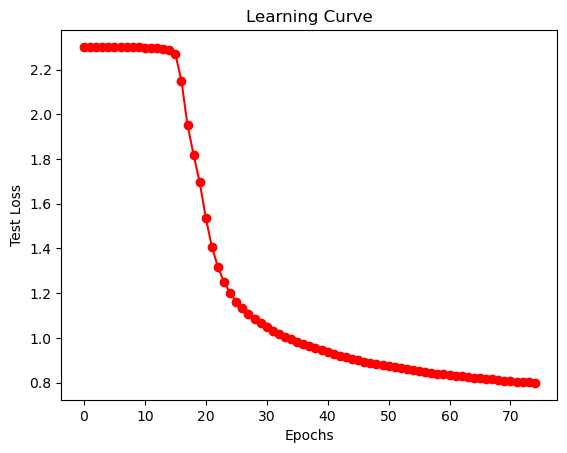

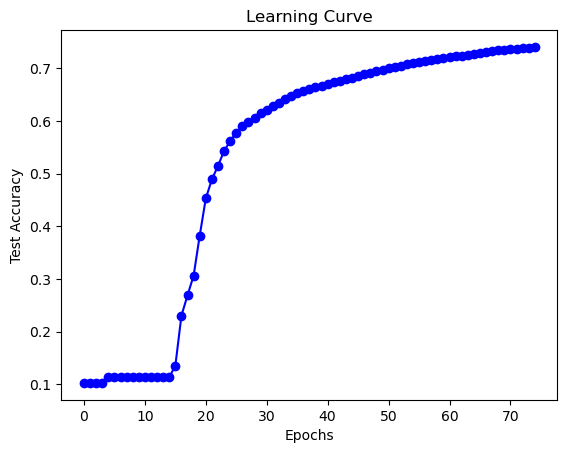

In [6]:
plot_mangrad_learning_curve(w1, b1, w2, b2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=10, bias=True)
  )
)
loss: 2.302585  [   64/60000]
loss: 2.296578  [ 6464/60000]
loss: 2.318174  [12864/60000]
loss: 2.310963  [19264/60000]
loss: 2.312971  [25664/60000]
loss: 2.310614  [32064/60000]
loss: 2.301440  [38464/60000]
loss: 2.307638  [44864/60000]
loss: 2.308934  [51264/60000]
loss: 2.290890  [57664/60000]
loss: 2.303029  [   64/60000]
loss: 2.296514  [ 6464/60000]
loss: 2.317945  [12864/60000]
loss: 2.311059  [19264/60000]
loss: 2.313010  [25664/60000]
loss: 2.310534  [32064/60000]
loss: 2.301274  [38464/60000]
loss: 2.307734  [44864/60000]
loss: 2.308970  [51264/60000]
loss: 2.290829  [57664/60000]
loss: 2.302956  [   64/60000]
loss: 2.296440  [ 6464/60000]
loss: 2.317697  [12864/60000]
loss: 2.311158  [19264/60000]
loss: 2.313043  [25664/60000]
los

loss: 1.136557  [38464/60000]
loss: 1.313548  [44864/60000]
loss: 1.204989  [51264/60000]
loss: 1.183196  [57664/60000]
loss: 1.138859  [   64/60000]
loss: 1.204675  [ 6464/60000]
loss: 1.236551  [12864/60000]
loss: 1.224869  [19264/60000]
loss: 1.149973  [25664/60000]
loss: 1.177164  [32064/60000]
loss: 1.109665  [38464/60000]
loss: 1.284803  [44864/60000]
loss: 1.174359  [51264/60000]
loss: 1.163164  [57664/60000]
loss: 1.113855  [   64/60000]
loss: 1.176476  [ 6464/60000]
loss: 1.212713  [12864/60000]
loss: 1.198624  [19264/60000]
loss: 1.127193  [25664/60000]
loss: 1.153060  [32064/60000]
loss: 1.086495  [38464/60000]
loss: 1.261073  [44864/60000]
loss: 1.149289  [51264/60000]
loss: 1.146536  [57664/60000]
loss: 1.092933  [   64/60000]
loss: 1.152424  [ 6464/60000]
loss: 1.192836  [12864/60000]
loss: 1.175316  [19264/60000]
loss: 1.107846  [25664/60000]
loss: 1.132490  [32064/60000]
loss: 1.066072  [38464/60000]
loss: 1.241169  [44864/60000]
loss: 1.128254  [51264/60000]
loss: 1.13

loss: 0.929537  [   64/60000]
loss: 0.911318  [ 6464/60000]
loss: 0.945901  [12864/60000]
loss: 0.891206  [19264/60000]
loss: 0.926806  [25664/60000]
loss: 0.923042  [32064/60000]
loss: 0.857449  [38464/60000]
loss: 1.058934  [44864/60000]
loss: 0.890242  [51264/60000]
loss: 0.986839  [57664/60000]
loss: 0.927840  [   64/60000]
loss: 0.906710  [ 6464/60000]
loss: 0.940147  [12864/60000]
loss: 0.888117  [19264/60000]
loss: 0.924742  [25664/60000]
loss: 0.920057  [32064/60000]
loss: 0.854359  [38464/60000]
loss: 1.055103  [44864/60000]
loss: 0.885972  [51264/60000]
loss: 0.984159  [57664/60000]
loss: 0.926286  [   64/60000]
loss: 0.902306  [ 6464/60000]
loss: 0.934604  [12864/60000]
loss: 0.885289  [19264/60000]
loss: 0.922820  [25664/60000]
loss: 0.917239  [32064/60000]
loss: 0.851384  [38464/60000]
loss: 1.051367  [44864/60000]
loss: 0.881944  [51264/60000]
loss: 0.981554  [57664/60000]
loss: 0.924867  [   64/60000]
loss: 0.898088  [ 6464/60000]
loss: 0.929252  [12864/60000]
loss: 0.88

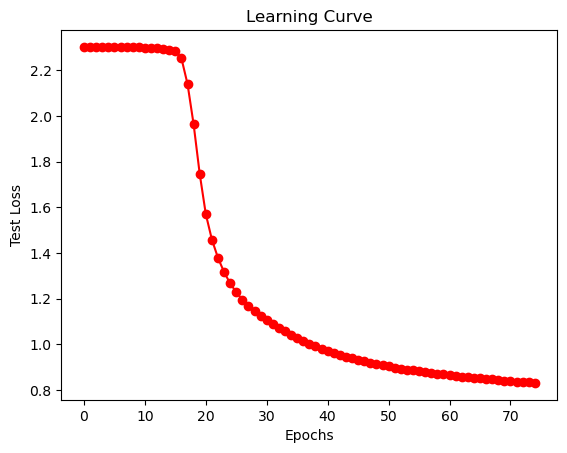

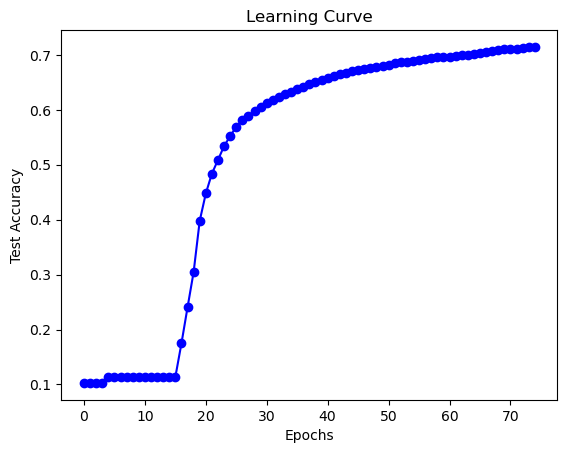

In [7]:
plot_autograd_learning_curve(w1, b1, w2, b2)

In [8]:

w1 = 2 * torch.rand((d1, d)) - 1
b1 = torch.zeros(d1)
w2 = 2 * torch.rand((k, d1)) - 1
b2 = torch.zeros(k)

loss: 8.975340  [   64/60000]
loss: 4.120883  [ 6464/60000]
loss: 3.518246  [12864/60000]
loss: 2.293324  [19264/60000]
loss: 1.682752  [25664/60000]
loss: 1.849065  [32064/60000]
loss: 1.517313  [38464/60000]
loss: 1.350277  [44864/60000]
loss: 1.366684  [51264/60000]
loss: 1.766740  [57664/60000]
loss: 1.106508  [   64/60000]
loss: 0.935863  [ 6464/60000]
loss: 1.001864  [12864/60000]
loss: 1.001812  [19264/60000]
loss: 0.724930  [25664/60000]
loss: 0.888895  [32064/60000]
loss: 0.851918  [38464/60000]
loss: 0.858545  [44864/60000]
loss: 0.843989  [51264/60000]
loss: 1.306550  [57664/60000]
loss: 0.713125  [   64/60000]
loss: 0.677567  [ 6464/60000]
loss: 0.647135  [12864/60000]
loss: 0.777610  [19264/60000]
loss: 0.510962  [25664/60000]
loss: 0.644853  [32064/60000]
loss: 0.684465  [38464/60000]
loss: 0.727055  [44864/60000]
loss: 0.680076  [51264/60000]
loss: 1.134266  [57664/60000]
loss: 0.573487  [   64/60000]
loss: 0.586932  [ 6464/60000]
loss: 0.520594  [12864/60000]
loss: 0.66

loss: 0.134335  [25664/60000]
loss: 0.226656  [32064/60000]
loss: 0.205648  [38464/60000]
loss: 0.403433  [44864/60000]
loss: 0.269608  [51264/60000]
loss: 0.657621  [57664/60000]
loss: 0.172198  [   64/60000]
loss: 0.253299  [ 6464/60000]
loss: 0.226677  [12864/60000]
loss: 0.239870  [19264/60000]
loss: 0.132675  [25664/60000]
loss: 0.223987  [32064/60000]
loss: 0.201782  [38464/60000]
loss: 0.399411  [44864/60000]
loss: 0.265943  [51264/60000]
loss: 0.652565  [57664/60000]
loss: 0.168679  [   64/60000]
loss: 0.248958  [ 6464/60000]
loss: 0.224226  [12864/60000]
loss: 0.236236  [19264/60000]
loss: 0.131096  [25664/60000]
loss: 0.221438  [32064/60000]
loss: 0.198165  [38464/60000]
loss: 0.395471  [44864/60000]
loss: 0.262444  [51264/60000]
loss: 0.647709  [57664/60000]
loss: 0.165342  [   64/60000]
loss: 0.244805  [ 6464/60000]
loss: 0.221861  [12864/60000]
loss: 0.232785  [19264/60000]
loss: 0.129592  [25664/60000]
loss: 0.218997  [32064/60000]
loss: 0.194774  [38464/60000]
loss: 0.39

loss: 0.206864  [51264/60000]
loss: 0.565835  [57664/60000]
loss: 0.112695  [   64/60000]
loss: 0.180850  [ 6464/60000]
loss: 0.178552  [12864/60000]
loss: 0.182303  [19264/60000]
loss: 0.104202  [25664/60000]
loss: 0.177087  [32064/60000]
loss: 0.146000  [38464/60000]
loss: 0.316609  [44864/60000]
loss: 0.205419  [51264/60000]
loss: 0.563474  [57664/60000]
loss: 0.111262  [   64/60000]
loss: 0.179326  [ 6464/60000]
loss: 0.177220  [12864/60000]
loss: 0.181197  [19264/60000]
loss: 0.103479  [25664/60000]
loss: 0.175865  [32064/60000]
loss: 0.144752  [38464/60000]
loss: 0.314389  [44864/60000]
loss: 0.204010  [51264/60000]
loss: 0.561151  [57664/60000]
loss: 0.109861  [   64/60000]
loss: 0.177851  [ 6464/60000]
loss: 0.175909  [12864/60000]
loss: 0.180134  [19264/60000]
loss: 0.102771  [25664/60000]
loss: 0.174666  [32064/60000]
loss: 0.143531  [38464/60000]
loss: 0.312220  [44864/60000]
loss: 0.202636  [51264/60000]
loss: 0.558865  [57664/60000]
loss: 0.108489  [   64/60000]
loss: 0.17

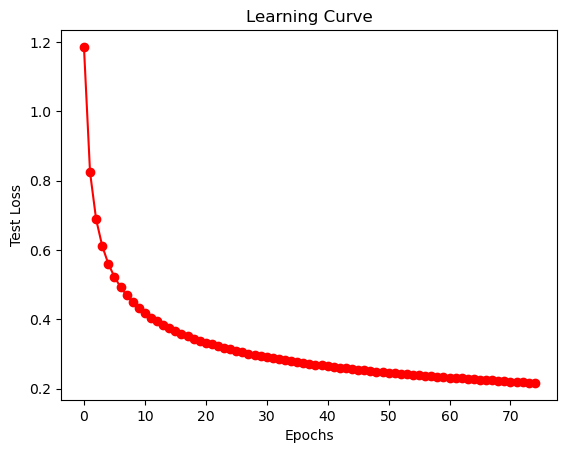

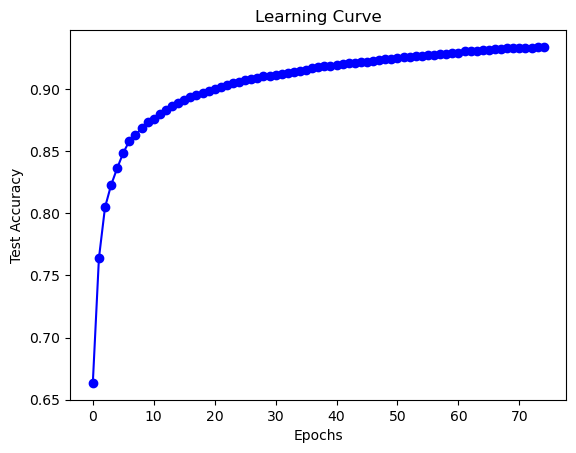

In [9]:
plot_mangrad_learning_curve(w1, b1, w2, b2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=10, bias=True)
  )
)
loss: 8.975340  [   64/60000]
loss: 4.120883  [ 6464/60000]
loss: 3.518247  [12864/60000]
loss: 2.293324  [19264/60000]
loss: 1.682752  [25664/60000]
loss: 1.849065  [32064/60000]
loss: 1.517314  [38464/60000]
loss: 1.350277  [44864/60000]
loss: 1.366684  [51264/60000]
loss: 1.766740  [57664/60000]
loss: 1.106508  [   64/60000]
loss: 0.935863  [ 6464/60000]
loss: 1.001864  [12864/60000]
loss: 1.001812  [19264/60000]
loss: 0.724930  [25664/60000]
loss: 0.888895  [32064/60000]
loss: 0.851918  [38464/60000]
loss: 0.858545  [44864/60000]
loss: 0.843989  [51264/60000]
loss: 1.306550  [57664/60000]
loss: 0.713125  [   64/60000]
loss: 0.677567  [ 6464/60000]
loss: 0.647134  [12864/60000]
loss: 0.777610  [19264/60000]
loss: 0.510962  [25664/60000]
los

loss: 0.209790  [38464/60000]
loss: 0.407544  [44864/60000]
loss: 0.273453  [51264/60000]
loss: 0.662889  [57664/60000]
loss: 0.175918  [   64/60000]
loss: 0.257841  [ 6464/60000]
loss: 0.229222  [12864/60000]
loss: 0.243704  [19264/60000]
loss: 0.134335  [25664/60000]
loss: 0.226656  [32064/60000]
loss: 0.205648  [38464/60000]
loss: 0.403433  [44864/60000]
loss: 0.269608  [51264/60000]
loss: 0.657621  [57664/60000]
loss: 0.172198  [   64/60000]
loss: 0.253299  [ 6464/60000]
loss: 0.226677  [12864/60000]
loss: 0.239870  [19264/60000]
loss: 0.132675  [25664/60000]
loss: 0.223987  [32064/60000]
loss: 0.201782  [38464/60000]
loss: 0.399411  [44864/60000]
loss: 0.265943  [51264/60000]
loss: 0.652565  [57664/60000]
loss: 0.168679  [   64/60000]
loss: 0.248958  [ 6464/60000]
loss: 0.224226  [12864/60000]
loss: 0.236236  [19264/60000]
loss: 0.131096  [25664/60000]
loss: 0.221438  [32064/60000]
loss: 0.198165  [38464/60000]
loss: 0.395471  [44864/60000]
loss: 0.262444  [51264/60000]
loss: 0.64

loss: 0.114160  [   64/60000]
loss: 0.182427  [ 6464/60000]
loss: 0.179906  [12864/60000]
loss: 0.183453  [19264/60000]
loss: 0.104941  [25664/60000]
loss: 0.178332  [32064/60000]
loss: 0.147276  [38464/60000]
loss: 0.318883  [44864/60000]
loss: 0.206864  [51264/60000]
loss: 0.565835  [57664/60000]
loss: 0.112695  [   64/60000]
loss: 0.180850  [ 6464/60000]
loss: 0.178552  [12864/60000]
loss: 0.182303  [19264/60000]
loss: 0.104202  [25664/60000]
loss: 0.177087  [32064/60000]
loss: 0.146000  [38464/60000]
loss: 0.316609  [44864/60000]
loss: 0.205419  [51264/60000]
loss: 0.563474  [57664/60000]
loss: 0.111263  [   64/60000]
loss: 0.179326  [ 6464/60000]
loss: 0.177220  [12864/60000]
loss: 0.181197  [19264/60000]
loss: 0.103479  [25664/60000]
loss: 0.175865  [32064/60000]
loss: 0.144752  [38464/60000]
loss: 0.314389  [44864/60000]
loss: 0.204010  [51264/60000]
loss: 0.561152  [57664/60000]
loss: 0.109861  [   64/60000]
loss: 0.177851  [ 6464/60000]
loss: 0.175909  [12864/60000]
loss: 0.18

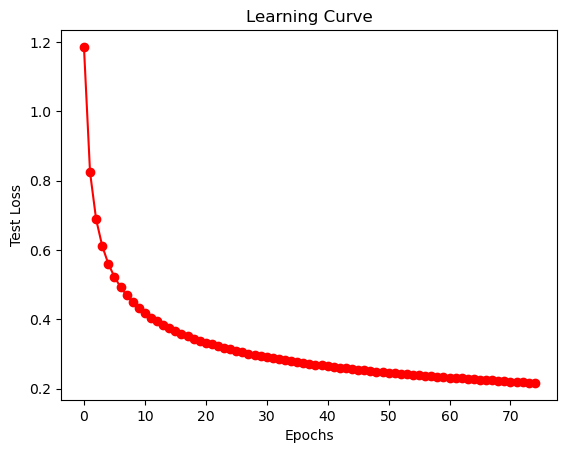

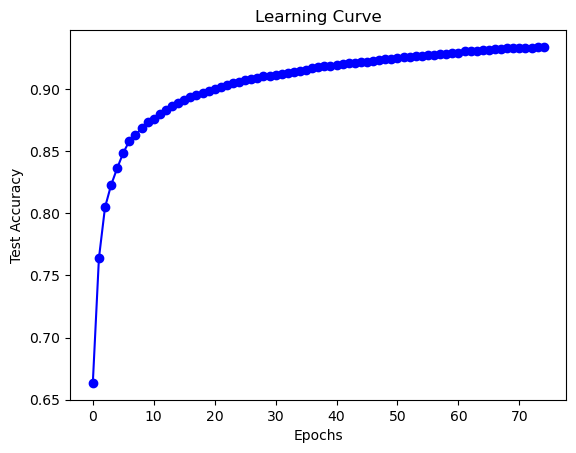

In [10]:
plot_autograd_learning_curve(w1, b1, w2, b2)

In [ ]:
### Problem 4 Testing (not part of the question)

# X -> flatten -> h1 -> out -> softmax -> cross entropy loss

d = 28 * 28 # Input Layer
d1 = 300    # Hidden Layer
k = 10      # Output Layer

In [ ]:
## Forward pass testing
## First construct equivalent pytorch model

torch.manual_seed(42)

# Inputs
N = 64
X = torch.rand(N, 28, 28)
Y = torch.randint(0, k, (N,))

# Params
linear1 = nn.Linear(28 * 28, 300)
linear2 = nn.Linear(300, 10)

# Model
net = nn.Sequential(
    nn.Flatten(),
    linear1,
    nn.Sigmoid(),
    linear2,
)

In [ ]:
# Pick the model weights for our forward pass

w1, b1 = linear1.weight.clone(), linear1.bias.clone()
w2, b2 = linear2.weight.clone(), linear2.bias.clone()

w1.shape, b1.shape, w2.shape, b2.shape

In [ ]:
# Manual Forward pass

# Flatten the input
# flat.shape = (N, d)
flat = X.view(N, -1)

# First hidden layer
lin1 = flat @ w1.T + b1
h1 = torch.sigmoid(lin1) # Sigmoid non-linearity

# Output layer
out = h1 @ w2.T + b2

# Softmax
maxb, _ = torch.max(out, axis=1, keepdim=True)
out = out - maxb # Keep the values non-positive to avoid blowing up the exponents
p = torch.exp(out)
p = p / p.sum(axis=1, keepdim=True) # Softmax

# Cross entropy loss
loss = -torch.mean(torch.log(torch.gather(p, 1, Y.unsqueeze(dim=1)))).item()


h1.shape, out.shape, p.shape, flat.shape

In [ ]:
# Compare loss output, our pass and model pass

outn = net(X)
tloss = F.cross_entropy(outn, Y)

loss, tloss

In [ ]:
# Manual Backward Pass

# cross_entropy grad
dout = (p - F.one_hot(Y)) / N

# Output Layer grad
dw2 = torch.sum(dout.unsqueeze(dim=2) @ h1.unsqueeze(dim=1), axis=0)
db2 = dout.sum(axis=0)
dh1 = dout @ w2

# Hidden Layer grad
dlin1 = dh1 * h1 * (1 - h1)
dw1 = torch.sum(dlin1.unsqueeze(dim=2) @ flat.unsqueeze(dim=1), axis=0)
db1 = dlin1.sum(axis=0)

dout.shape, dw2.shape, db2.shape, dh1.shape, dw1.shape, db1.shape

In [ ]:
# Backward pass on the model

# Zero out gradients
optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer.zero_grad()

outn = net(X)
tloss = F.cross_entropy(outn, Y)
tloss.backward()

In [ ]:
# Check gradients are equal

grad_label = ['w2', 'b2', 'w1', 'b1']
grad_actual = [linear2.weight.grad, linear2.bias.grad, linear1.weight.grad, linear1.bias.grad]
grad_pred = [dw2, db2, dw1, db1]
for label, actual, pred in zip(grad_label, grad_actual, grad_pred):
    tolerance = 1e-6
    approx_equal = torch.abs(actual - pred) < tolerance
    if not torch.all(approx_equal):
        print(label, actual, pred)

In [ ]:
# Pytorch
optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer.zero_grad()

outn = net(X)
tloss = F.cross_entropy(outn, Y)
tloss.backward()

In [ ]:
# Update

# Manual
lr = 0.001

w2 = w2 - lr * dw2
b2 = b2 - lr * db2
w1 = w1 - lr * dw1
b1 = b1 - lr * db1

# Model
optimizer.step()

In [ ]:
# Check params are equal

grad_label = ['w2', 'b2', 'w1', 'b1']
grad_actual = [linear2.weight.clone(), linear2.bias.clone(), linear1.weight.clone(), linear1.bias.clone()]
grad_pred = [w2, b2, w1, b1]
for label, actual, pred in zip(grad_label, grad_actual, grad_pred):
    tolerance = 1e-6
    approx_equal = torch.abs(actual - pred) < tolerance
    if not torch.all(approx_equal):
        print(label, actual, pred)

In [ ]:
## More Testing

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# X -> flatten -> h1 -> out -> softmax -> cross entropy loss

d = 28 * 28 # Input Layer
d1 = 512    # Hidden Layer
k = 10      # Output Layer

torch.manual_seed(42)
N = 64
X = torch.rand(N, 28, 28)
Y = torch.randint(0, k, (N,))
lr = 0.001

# Params
linear1 = nn.Linear(28 * 28, 512)
linear2 = nn.Linear(512, 10)

# Model
net = nn.Sequential(
    nn.Flatten(),
    linear1,
    nn.Sigmoid(),
    linear2,
)

In [ ]:
# Forward pass

class MLP:
    def __init__(self):
        d = 28 * 28
        d1 = 512
        k = 10
        
        # Hidden Layer
        self.w1 = torch.empty((d1, d))
        self.b1 = torch.empty(d1)
        nn.init.kaiming_uniform_(self.w1, a=math.sqrt(5))
        bound = 1 / math.sqrt(d)
        nn.init.uniform_(self.b1, -bound, bound)
        
        # Output Layer
        self.w2 = torch.empty((k, d1))
        self.b2 = torch.empty(k)
        nn.init.kaiming_uniform_(self.w2, a=math.sqrt(5))
        bound = 1 / math.sqrt(d1)
        nn.init.uniform_(self.b2, -bound, bound)
        
    def backprop(self, X, Y):
        ## Forward Pass
        
        # Hidden Layer
        N = X.size(0)
        flat = X.view(N, -1)
        lin1 = flat @ self.w1.T + self.b1
        h1 = torch.sigmoid(lin1) # sigmoid non-linearity
        
        # Output Layer
        logits = h1 @ self.w2.T + self.b2
        
        # Softmax
        maxb, _ = torch.max(logits, axis=1, keepdim=True)
        logits = logits - maxb # Keep the values non-positive to avoid blowing up the exponents
        p = torch.exp(logits)
        p = p / p.sum(axis=1, keepdim=True) # Softmax
        
        # Cross Entropy
        loss = -torch.mean(torch.log(torch.gather(p, 1, Y.unsqueeze(dim=1)))).item()
        
        ## Backward Pass
        # cross_entropy grad
        dout = (p - F.one_hot(Y)) / N

        # Output Layer grad
        dw2 = torch.sum(dout.unsqueeze(dim=2) @ h1.unsqueeze(dim=1), axis=0)
        db2 = dout.sum(axis=0)
        dh1 = dout @ self.w2

        # Hidden Layer grad
        dlin1 = dh1 * h1 * (1 - h1)
        dw1 = torch.sum(dlin1.unsqueeze(dim=2) @ flat.unsqueeze(dim=1), axis=0)
        db1 = dlin1.sum(axis=0)
        
        # Update
        self.w2 = self.w2 - lr * dw2
        self.b2 = self.b2 - lr * db2
        self.w1 = self.w1 - lr * dw1
        self.b1 = self.b1 - lr * db1
        
        return loss
    
    def copy_params(self):
        self.w1, self.b1 = linear1.weight.clone(), linear1.bias.clone()
        self.w2, self.b2 = linear2.weight.clone(), linear2.bias.clone()
        
    
mlp = MLP()

In [ ]:
mlp.copy_params()

In [ ]:
# Optimize

optimizer = optim.SGD(net.parameters(), lr=lr)

for idx in range(1000):
    # Optimize model
    optimizer.zero_grad()
    outn = net(X)
    tloss = F.cross_entropy(outn, Y)
    tloss.backward() # Backward pass
    optimizer.step() # Update step
    
    # Manual opt
    loss = mlp.backprop(X, Y)
    
    
    if not math.isclose(loss, tloss, rel_tol=1e-3):
        print(idx, tloss.item(), loss)
        break

In [ ]:
# Example showing error bars

import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
x = np.linspace(0, 10, 20)
y = np.sin(x) + np.random.normal(0, 0.1, 20)  # Adding some noise to y values
error = np.abs(np.random.normal(0.1, 0.05, 20))  # Simulated error

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot learning curve
plt.plot(x, y, label='Learning Curve', marker='o', color='b')

# Plot error bars
plt.errorbar(x, y, yerr=error, fmt='o', ecolor='r', capsize=4, label='Error Bars')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve with Error Bars')

# Add legend
plt.legend()

# Show plot
plt.show()